In [50]:
#loading needed libraries
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(modelr)
library(dplyr)

In [76]:
options(repr.plot.width = 15, repr.plot.height =5) 

In [77]:
repositories <- read_csv("repositories.csv") # reading data 

repositories <- repositories %>%
  rename(Has_discussions = `Has Discussions`,
         Has_projects = `Has Projects`,
         Has_wiki = `Has Wiki`,
         Has_pages = `Has Pages`,
         is_template = `Is Template`) %>% 
  mutate(Has_discussions = as.factor(Has_discussions),
        Has_projects = as.factor(Has_projects),
         Has_wiki = as.factor(Has_wiki),
         Has_pages = as.factor(Has_pages)) %>%
  select(Stars, Size, Forks, Has_discussions, Has_projects, Has_wiki, Has_pages, is_template, Issues) |> # selecting relevant columns
  drop_na()

head(repositories)

Rows: 113821 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): Name, Description, URL, Homepage, Language, License, Topics, Defau...
dbl  (5): Size, Stars, Forks, Issues, Watchers
lgl  (9): Has Issues, Has Projects, Has Downloads, Has Wiki, Has Pages, Has ...
dttm (2): Created At, Updated At

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Stars  Size   Forks Has_discussions Has_projects Has_wiki Has_pages
1 374074 387451 33599 FALSE           TRUE         FALSE    TRUE     
2 298393  17087 57194 FALSE           FALSE        FALSE    TRUE     
3 269997   1441 26485 FALSE           FALSE        FALSE    TRUE     
4 267901 187799 21497 FALSE           FALSE        FALSE    FALSE    
5 265161  20998 69434 FALSE           FALSE        FALSE    FALSE    
6 256615   5088 29254 FALSE           FALSE        FALSE    FALSE    
  is_template Issues
1 FALSE         248 
2 FALSE          46 
3 FALSE          61 
4 FALSE       16712 
5 FALSE          56 
6 FALSE         191

In [78]:
repositories_sample <- repositories %>%
  sample_n(2000)

In [84]:
# table for summary statisitcs of continuous variables
summary_table <- data.frame(
  Variable = c("Size", "Stars", "Issues"),
  Min = c(0, 353, 0),
  `1st Qu.` = c(562, 486, 5),
  Median = c(3402, 751, 16),
  Mean = c(63441, 1893, 56.78),
  `3rd Qu.` = c(20286, 1546, 45),
  Max = c(104880243, 374074, 26543))

summary_table

Variable Min X1st.Qu. Median Mean     X3rd.Qu. Max      
1 Size       0 562      3402   63441.00 20286    104880243
2 Stars    353 486       751    1893.00  1546       374074
3 Issues     0   5        16      56.78    45        26543

All the selected continuous variables in our dataset had right-skewed distributions. This skewness, as well as the extremly large ranges and the presence of extreme outliers, could potentially distort statistical analyses and reduce the interpretability of our data. This indicated the need for a transformation to address these challenges. Applying a log transformation seemed appropriate as it helps stabilize the variance, making the data more homoscedastic, and lessens the impact of extreme values. This approach makes the modeling process more reliable and helps us better understand the relationships between variables, especially when making predictions.

Warning message:
“Removed 78 rows containing non-finite outside the scale range (`stat_bin()`).”


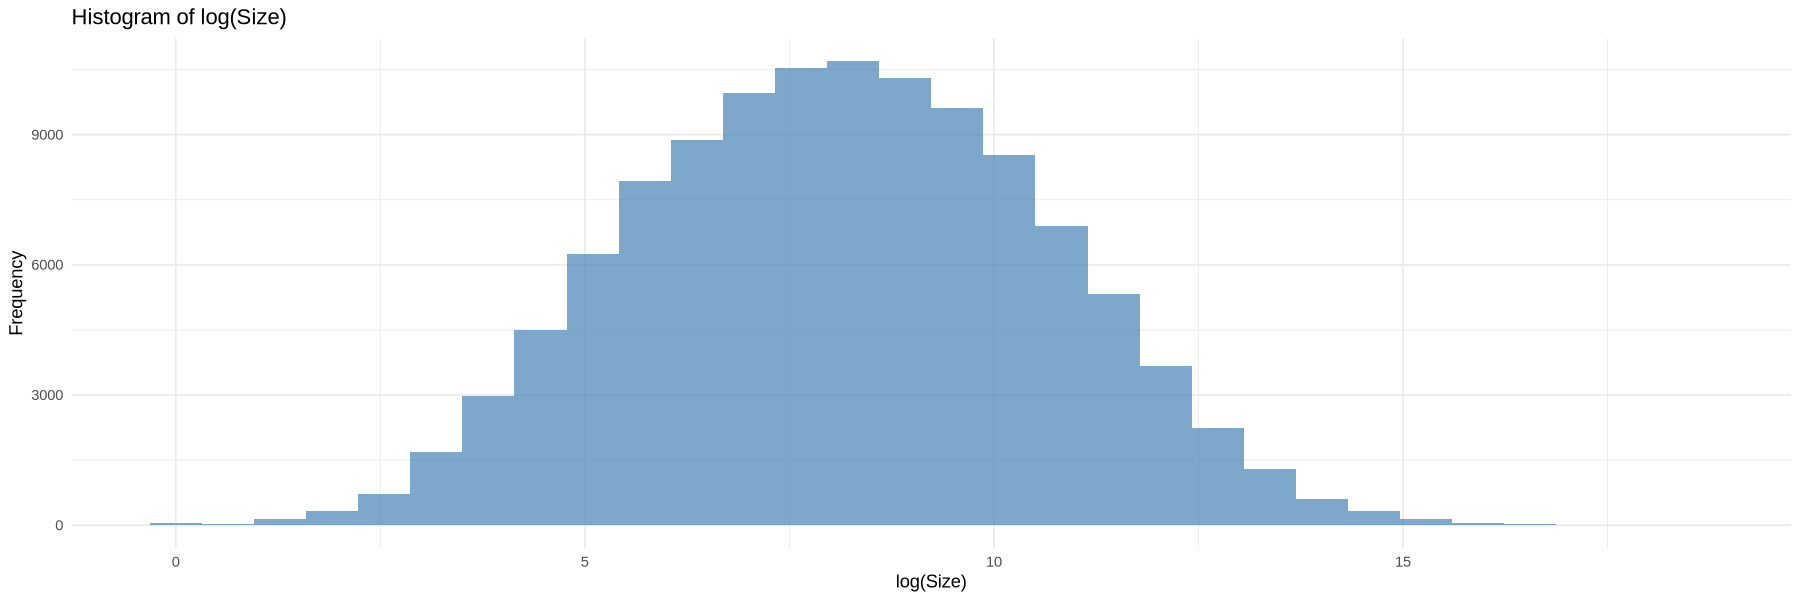

In [79]:
p1 <- ggplot(repositories, aes(x = log(Size))) +
  geom_histogram(bins = 30, fill = "steelblue", alpha = 0.7) +
  ggtitle("Histogram of log(Size)") +
  xlab("log(Size)") +
  ylab("Frequency") +
  theme_minimal()

p1

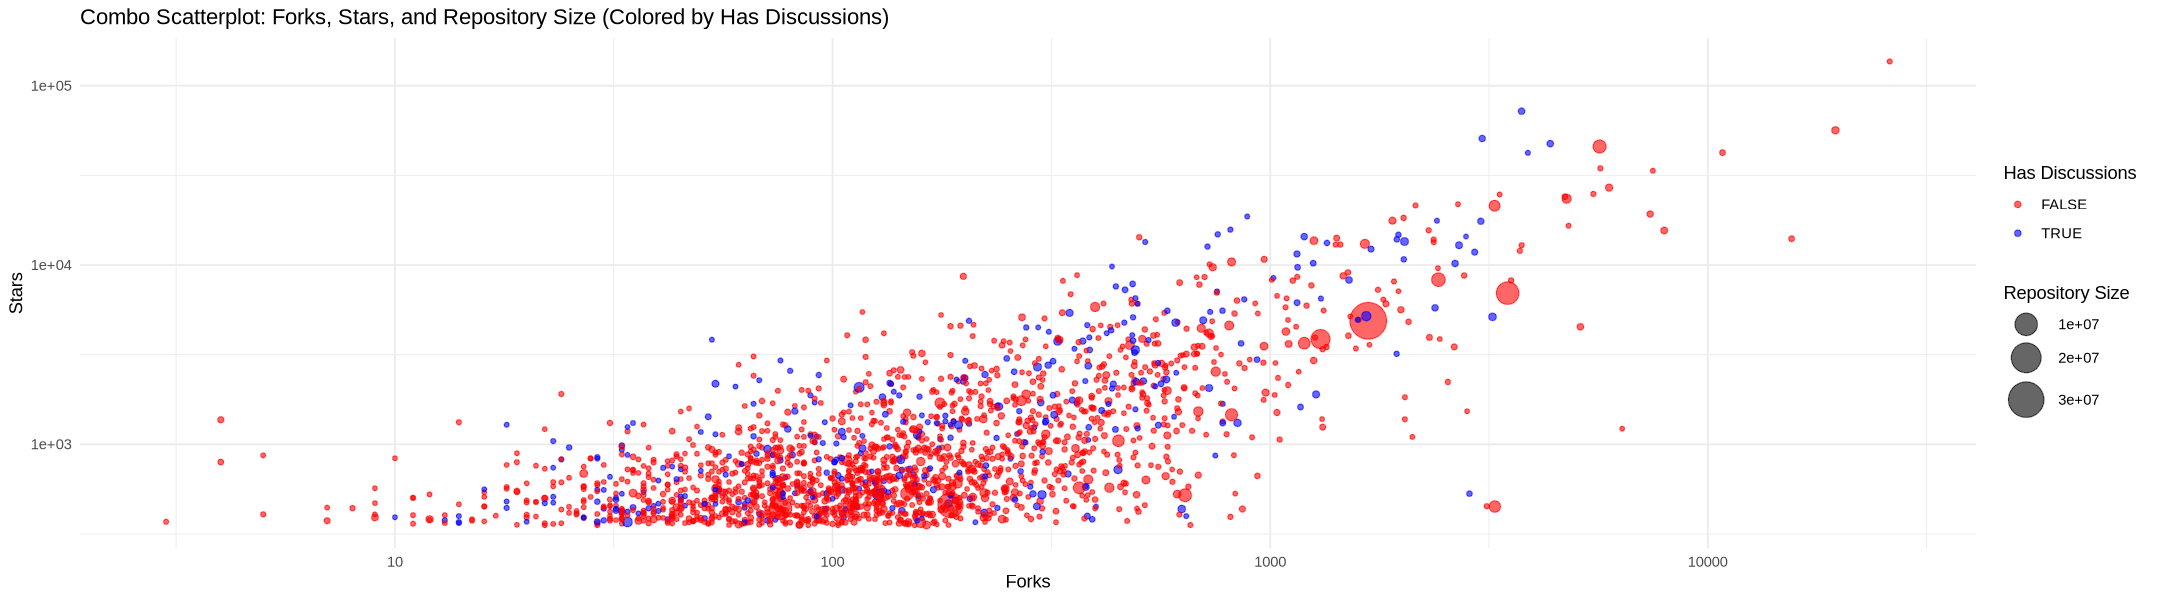

In [55]:
#plot 2: scatterplot of stars vs forks, point size represents repository size and is colored for has_discussions
p2 <- repositories_sample %>%
    ggplot(aes(x = Forks, y = Stars, color = Has_discussions, size = Size)) +  
    geom_point(alpha = 0.6) +  # semi transparent points to make it easier to visualize even when overlapping
    scale_size(range = c(1, 10)) +  # adjusting size of the points based on size of repository
    scale_color_manual(values = c("red", "blue")) + 
    labs(title = "Combo Scatterplot: Forks, Stars, and Repository Size (Colored by Has Discussions)",
         x = "(Logged) Forks",
         y = "(Logged) Stars",
         size = "Repository Size",
         color = "Has Discussions") +
    scale_x_log10() +
    scale_y_log10() +
    theme_minimal()

p2


For this combination scatterplot, there seems to be a positive association between (logged) `Forks` and (logged) `Stars`, with repositories having discussions enabled (blue) being more common among those with higher star and fork counts. When examining the sizes of the data points, there doesn’t appear to be a clear pattern based on `Star` levels, suggesting a very weak or nonexistent relationship between (logged) `Stars` and repository `Size`.

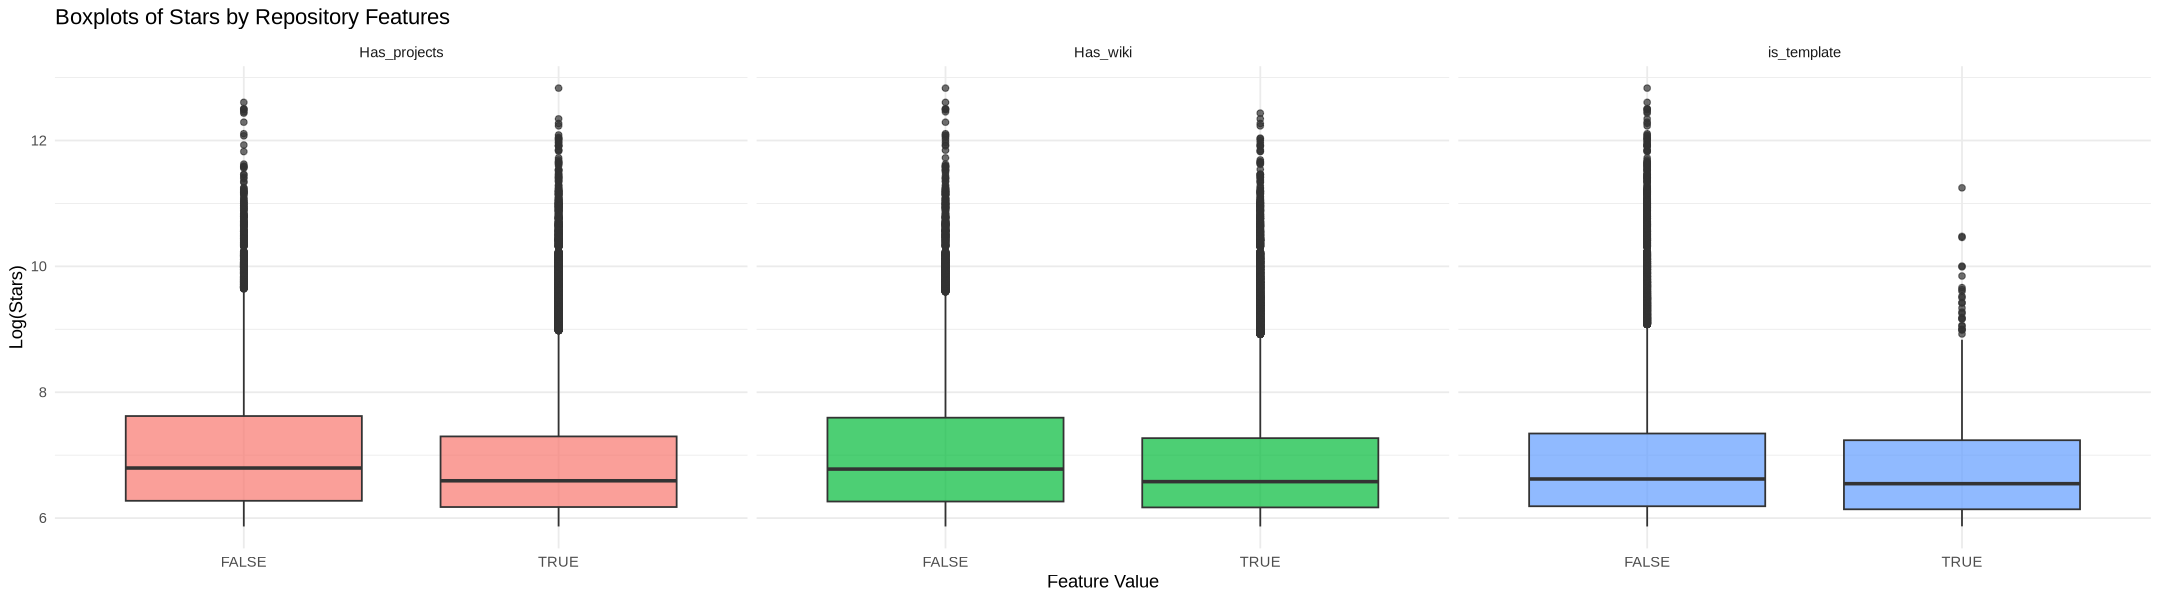

In [65]:
repositories <- repositories %>%
  mutate(across(c(Has_projects, Has_wiki, is_template), as.factor))

p3 <- repositories %>%
  pivot_longer(cols = c(Has_projects, Has_wiki, is_template),
               names_to = "Variable",
               values_to = "Value") %>%
  ggplot(aes(x = Value, y = log(Stars), fill = Variable)) +
  geom_boxplot(alpha = 0.7) +
  facet_wrap(~ Variable, ncol = 4) +
  labs(title = "Boxplots of Stars by Repository Features",
       x = "Feature Value",
       y = "Log(Stars)") +
  theme_minimal() +
  theme(legend.position = "none")

p3

For the `Has_projects` boxplot, it appears that repositories without projects tend to have a higher average number of stars. Similarly, the `Has_wiki` boxplot suggests that repositories without an associated wiki tend to have a higher average number of stars. Lastly, for the `is_template` boxplot, the number of stars does not vary significantly based on whether a repository is a template, although the average is slightly higher for repositories that are not templates. Overall, none of these differences seem substantial at first glance, which might indicate a lack of a strong relationship between the number of stars and these variables.